In [ ]:
# 1. Imports & configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)
sns.set_theme()

In [ ]:
!pip install -U xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

from pathlib import Path

base = Path("/content/drive/MyDrive/MUTERLOGER/v2")
fichiers = {
    "Appartements": "Appartements.csv",
    "Maisons": "Maison.csv",
    "1-2 pièces": "Apparte1Ou2Piece.csv",
    "3+ pièces": "Apparte3PiecesOuPlus.csv",
}

def charge_annee(annee):
    dfs = []
    for type_logement, fname in fichiers.items():
        df = pd.read_csv(base/str(annee)/fname, sep=";", encoding="ISO-8859-1")
        df["type_logement"] = type_logement
        df["annee"] = annee
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df_2022 = charge_annee(2022)
df_2023 = charge_annee(2023)
df_2024 = charge_annee(2024)

# Concat final
df_all = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)
print(df_all.shape)
df_all.head()


(419640, 15)


,id_zone,INSEE_C,LIBGEO,EPCI,DEP,REG,loypredm2,lwr.IPm2,upr.IPm2,TYPPRED,nbobs_com,nbobs_mail,R2_adj,type_logement,annee
0,1,64308,Lalonquette,200067239,64,75,"8,21522217793632","7,02394007559614","9,6085494332935",maille,2,755,"0,849258038087416",Appartements,2022
1,1,64239,Gerderest,200067296,64,75,"8,21522217793632","7,02394007559614","9,6085494332935",maille,3,755,"0,849258038087416",Appartements,2022
2,1,64514,Séby,200067239,64,75,"8,21522217793632","7,02394007559614","9,6085494332935",maille,1,755,"0,849258038087416",Appartements,2022
3,1,64524,Simacourbe,200067296,64,75,"8,21522217793632","7,02394007559614","9,6085494332935",maille,1,755,"0,849258038087416",Appartements,2022
4,1,64486,Saint-Jean-Poudge,200067239,64,75,"8,21522217793632","7,02394007559614","9,6085494332935",maille,0,755,"0,849258038087416",Appartements,2022


,INSEE_C,LIBGEO,DEP,REG,loypredm2,type_logement,annee
0,64308,Lalonquette,64,75,"8,21522217793632",Appartements,2022
1,64239,Gerderest,64,75,"8,21522217793632",Appartements,2022
2,64514,Séby,64,75,"8,21522217793632",Appartements,2022
3,64524,Simacourbe,64,75,"8,21522217793632",Appartements,2022
4,64486,Saint-Jean-Poudge,64,75,"8,21522217793632",Appartements,2022


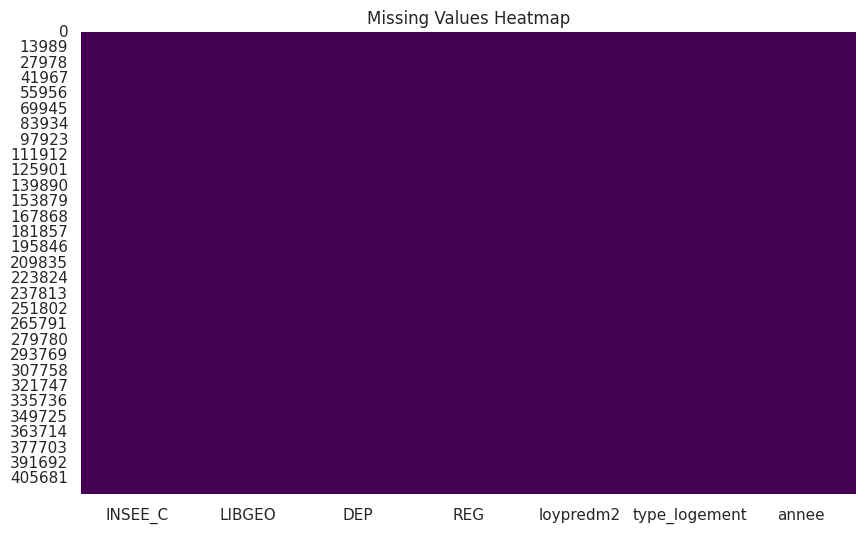

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_all.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [ ]:
# Harmonisation des colonnes & dtypes
df_all.columns = (
    df_all.columns
    .str.strip()
    .str.replace('\u200b', '', regex=False)  # caractères invisibles éventuels
)

# Si les nombres sont en "virgule": relire avec decimal="," (décommente si nécessaire)
# df_all = pd.read_csv(..., sep=";", encoding="ISO-8859-1", decimal=",")

# Forcer certains dtypes en string (préserve zéros à gauche)
for col in ["INSEE_C", "DEP", "REG", "CODEPOSTAL"]:
    if col in df_all.columns:
        df_all[col] = df_all[col].astype(str).str.strip()

# Normaliser type_logement en catégorie
df_all["type_logement"] = df_all["type_logement"].astype("category")

# Option : fabriquer departement à partir du code INSEE si besoin
if "DEP" not in df_all.columns and "INSEE_C" in df_all.columns:
    df_all["DEP"] = df_all["INSEE_C"].str[:2]


In [ ]:
def cols_by_year(df, year_col="annee"):
    d = {}
    for a, g in df.groupby(year_col):
        d[a] = set(g.columns)
    return d

schema = cols_by_year(df_all)
base_cols = None
for annee, cols in sorted(schema.items()):
    if base_cols is None:
        base_cols = cols
    diff = cols ^ base_cols
    if diff:
        print(f"⚠️ Différences de colonnes pour {annee}: {sorted(diff)}")
    else:
        print(f"✓ Schéma identique en {annee}")


✓ Schéma identique en 2022
✓ Schéma identique en 2023
✓ Schéma identique en 2024


In [ ]:
# 1) Colonnes identiques entre 2022 et 2023 ?
diff = set(df_2022.columns).symmetric_difference(df_2023.columns)
print("Diff colonnes:", diff)  # doit être set() vide

# 2) Types de colonnes
df_all.dtypes


Diff colonnes: set()


,0
INSEE_C,object
LIBGEO,object
DEP,object
REG,object
loypredm2,object
type_logement,category
annee,int64


In [ ]:


df_all["loypredm2"] = (df_all["loypredm2"].astype(str).str.replace(",", ".", regex=False)   # remplace virgule par point
                       .str.replace("\u00A0", "", regex=False)  # enlève espaces insécables
                       .str.strip()
                       )
df_all["loypredm2"] = pd.to_numeric(df_all["loypredm2"], errors="coerce")  # conversion en float

df_all["loypredm2"].dtypes


dtype('float64')

In [ ]:
print(df_all["loypredm2"].describe())


count    419640.000000
mean          9.562868
std           2.628955
min           4.902666
25%           7.684694
50%           9.086907
75%          10.885369
max          39.415339
Name: loypredm2, dtype: float64


In [ ]:
df_all.groupby(["annee", "type_logement"])["loypredm2"].mean()


/tmp/ipython-input-3477652238.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_all.groupby(["annee", "type_logement"])["loypredm2"].mean()


annee  type_logement
2022   1-2 pièces       11.241790
       3+ pièces         8.093025
       Appartements      9.384527
       Maisons           8.195775
2023   1-2 pièces       11.613047
       3+ pièces         8.354783
       Appartements      9.683927
       Maisons           8.533138
2024   1-2 pièces       11.962286
       3+ pièces         8.707433
       Appartements     10.060693
       Maisons           8.924772
Name: loypredm2, dtype: float64

In [ ]:
pivot = df_all.groupby(["type_logement", "annee"])["loypredm2"].mean().unstack()
pivot["evolution_%"] = (pivot[2023] - pivot[2022]) / pivot[2022] * 100
print(pivot)


annee               2022       2023       2024  evolution_%
type_logement                                              
1-2 pièces     11.241790  11.613047  11.962286     3.302469
3+ pièces       8.093025   8.354783   8.707433     3.234364
Appartements    9.384527   9.683927  10.060693     3.190361
Maisons         8.195775   8.533138   8.924772     4.116303


/tmp/ipython-input-2807945447.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = df_all.groupby(["type_logement", "annee"])["loypredm2"].mean().unstack()


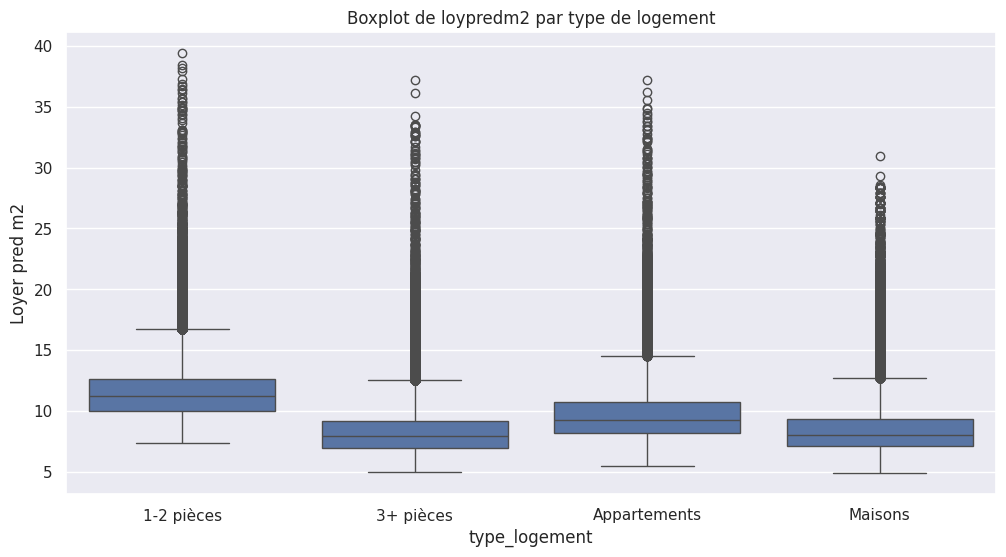

/tmp/ipython-input-963513673.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = df_all.groupby(["annee", "type_logement"])["loypredm2"].mean().reset_index()


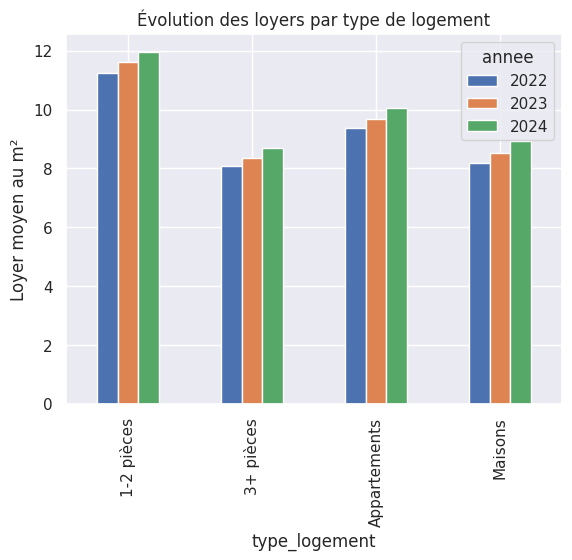

In [ ]:
import matplotlib.pyplot as plt

pivot = df_all.groupby(["annee", "type_logement"])["loypredm2"].mean().reset_index()
pivot.pivot(index="type_logement", columns="annee", values="loypredm2").plot(kind="bar")
plt.ylabel("Loyer moyen au m²")
plt.title("Évolution des loyers par type de logement")
plt.show()


In [ ]:
df_clean = df_all.copy()


# Cible et features candidates
target = "loypredm2"
cand_cat = [c for c in ["DEP", "REG", "type_logement"] if c in df_clean.columns]

# Largeur d'intervalle comme feature d’incertitude
if {"lwr.IPm2", "upr.IPm2"}.issubset(df_clean.columns):
    df_clean["ip_width"] = (df_clean["upr.IPm2"] - df_clean["lwr.IPm2"]).astype(float)

features = cand_cat
df_model = df_clean.dropna(subset=[target] + features).copy()
print("Taille après nettoyage:", df_model.shape)
print("Features retenues:", features)


Taille après nettoyage: (419640, 7)
Features retenues: ['DEP', 'REG', 'type_logement']


In [ ]:
# --- Encodage avec get_dummies + modèles avancés (XGBoost / LightGBM / CatBoost) ---

from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# (optionnel) si besoin d'installer les libs dans Colab :
# !pip install xgboost lightgbm catboost -q

# Imports optionnels (ne plante pas si non installés)
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except Exception:
    HAS_CAT = False

# --------- Données ---------
X = df_model[features].copy()
y = df_model[target].astype(float).copy()

# Split par commune si dispo
if "INSEE_C" in df_model.columns:
    groups = df_model["INSEE_C"].astype(str)
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
    tr_idx, te_idx = next(gss.split(X, y, groups))
else:
    tr_idx, te_idx = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)

X_train, X_test = X.iloc[tr_idx].copy(), X.iloc[te_idx].copy()
y_train, y_test = y.iloc[tr_idx].copy(), y.iloc[te_idx].copy()

# Colonnes catégorielles et numériques (déjà définies dans features via cand_cat/cand_num)
cat_cols = [c for c in X_train.columns if c in cand_cat]
num_cols = [c for c in X_train.columns if c in cand_num]

# Encodage one-hot avec pandas (sur train, puis on aligne test)
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
X_test  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=False)

# Aligner les colonnes (test prend les colonnes train; manquantes => 0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# --------- Modèles ---------
models = []

# Régression linéaire (baseline)
models.append(("LinearRegression",
               LinearRegression()))

# HistGradientBoosting (fort sur tabulaire)
models.append(("HistGradientBoosting",
               HistGradientBoostingRegressor(random_state=42)))

# XGBoost
if HAS_XGB:
    models.append(("XGBRegressor",
                   XGBRegressor(
                       n_estimators=600,
                       max_depth=8,
                       learning_rate=0.05,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       reg_lambda=1.0,
                       random_state=42,
                       tree_method="hist",
                       n_jobs=-1
                   )))

# LightGBM
if HAS_LGBM:
    models.append(("LGBMRegressor",
                   LGBMRegressor(
                       n_estimators=1000,
                       num_leaves=63,
                       learning_rate=0.05,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       reg_lambda=1.0,
                       random_state=42
                   )))

# CatBoost (utilise les dummies ici; verbose=0 pour rester propre)
if HAS_CAT:
    models.append(("CatBoostRegressor",
                   CatBoostRegressor(
                       iterations=1000,
                       depth=8,
                       learning_rate=0.05,
                       loss_function="RMSE",
                       random_state=42,
                       verbose=0
                   )))

# --------- Entraînement + Évaluation ---------
def evalreg(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # compat toutes versions
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return pd.Series({"MAE": mae, "RMSE": rmse, "R2": r2})

results = []
fitted = {}

for name, model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    metrics = evalreg(y_test, pred).to_dict()
    results.append({"Model": name, **metrics})
    fitted[name] = model

res = pd.DataFrame(results).sort_values("RMSE")
print(res)

# Meilleur modèle
best_name = res.iloc[0]["Model"]
best_model = fitted[best_name]
print(f"\nMeilleur modèle: {best_name}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 335712, number of used features: 121
[LightGBM] [Info] Start training from score 9.567966
                  Model       MAE      RMSE        R2
3         LGBMRegressor  0.980870  1.342295  0.735392
4     CatBoostRegressor  0.981004  1.342448  0.735331
2          XGBRegressor  0.981549  1.342798  0.735193
1  HistGradientBoosting  0.984221  1.345496  0.734128
0      LinearRegression  1.004045  1.369449  0.724578

Meilleur modèle: LGBMRegressor


In [ ]:
def clean_columns(df):
    # remplace espaces, /, -, etc. par _
    return df.rename(columns=lambda c: (
        str(c)
        .strip()
        .replace(" ", "_")
        .replace("/", "_")
        .replace("-", "_")
        .replace("(", "")
        .replace(")", "")
    ))

X_train = clean_columns(X_train)
X_test  = clean_columns(X_test)


In [ ]:
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

# split train -> (train_in, valid) par groupes
if "INSEE_C" in df_model.columns:
    groups_train = df_model.iloc[tr_idx]["INSEE_C"].astype(str).values
    gss_inner = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
    tr_in_idx, val_idx = next(gss_inner.split(X_train, y_train, groups_train))
else:
    rng = np.random.RandomState(123)
    idx = np.arange(len(X_train))
    rng.shuffle(idx)
    cut = int(0.8 * len(idx))
    tr_in_idx, val_idx = idx[:cut], idx[cut:]

X_tr_in, y_tr_in = X_train.iloc[tr_in_idx], y_train.iloc[tr_in_idx]
X_val,   y_val   = X_train.iloc[val_idx],   y_train.iloc[val_idx]


In [ ]:
import pandas as pd
import numpy as np

def feature_importance_df(model, cols, kind="gain"):
    # XGBoost
    if hasattr(model, "get_booster"):
        booster = model.get_booster()
        fmap = booster.get_score(importance_type=kind)
        imp = pd.DataFrame({"feature": list(fmap.keys()),
                            "importance": list(fmap.values())})
        # remet l'index de colonnes si XGB a renommé en f0, f1…
        if set(imp["feature"]) <= set(cols):
            imp["feature"] = imp["feature"]
        else:
            # map f0->cols[0]
            imp["feature"] = imp["feature"].str.extract(r"f(\d+)").astype(int).iloc[:,0].map(dict(enumerate(cols)))
        return imp.sort_values("importance", ascending=False)
    # LightGBM
    if hasattr(model, "feature_importances_"):
        return (pd.DataFrame({"feature": cols, "importance": model.feature_importances_})
                .sort_values("importance", ascending=False))
    return pd.DataFrame(columns=["feature","importance"])

# Exemple
imp_xgb = feature_importance_df(xgb_es, X_train.columns, kind="gain").head(30)
imp_lgb = feature_importance_df(lgbm_es, X_train.columns).head(30)
display(imp_xgb.head(10))
display(imp_lgb.head(10))

ValueError: cannot convert float NaN to integer

In [ ]:
# suppose qu’on a conservé l’index aligné pour X_test ; récupère DEP du df_model
test_dep = df_model.iloc[te_idx]["DEP"].astype(str).values if "DEP" in df_model.columns else None
err = pd.DataFrame({
    "DEP": test_dep,
    "abs_err": np.abs(y_test.values - pred_xgb)
})
err_dep = err.groupby("DEP")["abs_err"].mean().sort_values(ascending=False)
display(err_dep.head(15))


,abs_err
DEP,
06,1.253724
75,1.232122
92,1.058585
77,0.853408
93,0.838834
74,0.777803
91,0.722122
94,0.703727
95,0.701641


In [ ]:
# ====== GridSearchCV (GroupKFold + RMSE) pour XGBoost / LightGBM ======
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

# -- Scorer RMSE (negatif pour GridSearchCV car il maximise la métrique) --
def rmse_func(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_func, greater_is_better=False)

# -- Splitter de CV (par commune si dispo) --
if "INSEE_C" in df_model.columns:
    groups_train = df_model.iloc[tr_idx]["INSEE_C"].astype(str)
    cv = GroupKFold(n_splits=5)
else:
    groups_train = None
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

# -- Fonctions utilitaires --
def evaluate_on_test(model, X_te, y_te):
    y_hat = model.predict(X_te)
    mae = mean_absolute_error(y_te, y_hat)
    rmse = rmse_func(y_te, y_hat)
    r2 = r2_score(y_te, y_hat)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

grid_results = []

# ================= XGBOOST =================
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(
        random_state=42,
        tree_method="hist",
        n_jobs=-1
    )
    # Grille "raisonnable"
    xgb_grid = {
        "n_estimators": [1500, 5000, 10000],
        "learning_rate": [0.03, 0.05, 0.1],
        "subsample": [0.7, 0.9],
        "colsample_bytree": [0.7, 0.9],
        "reg_lambda": [0.0, 1.0]
    }

    xgb_gs = GridSearchCV(
        estimator=xgb,
        param_grid=xgb_grid,
        scoring=rmse_scorer,
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=1
    )
    xgb_gs.fit(X_train, y_train, groups=groups_train) # Added groups=groups_train back
    xgb_best = xgb_gs.best_estimator_
    xgb_cv_rmse = -xgb_gs.best_score_
    xgb_test = evaluate_on_test(xgb_best, X_test, y_test)

    print("\n[XGBoost] Best params:", xgb_gs.best_params_)
    print("[XGBoost] Best CV RMSE:", xgb_cv_rmse)
    print("[XGBoost] TEST:", xgb_test)

    grid_results.append({"Model": "XGBRegressor", "CV_RMSE": xgb_cv_rmse, **xgb_test, "BestParams": xgb_gs.best_params_})

except Exception as e:
    print("XGBoost non disponible ou erreur:", e)

# ================= LIGHTGBM =================
try:
    from lightgbm import LGBMRegressor
    lgbm = LGBMRegressor(random_state=42)

    # Grille "raisonnable" (taille ~3*3*3*2*2 = 108 combos)
    lgbm_grid = {
        "n_estimators": [1500, 5000, 10000],
        "num_leaves": [31, 63, 127],
        "learning_rate": [0.03, 0.05, 0.1],
        "subsample": [0.7, 0.9],
        "colsample_bytree": [0.7, 0.9],
        "reg_lambda": [0.0, 1.0],
    }

    lgbm_gs = GridSearchCV(
        estimator=lgbm,
        param_grid=lgbm_grid,
        scoring=rmse_scorer,
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=1
    )
    lgbm_gs.fit(X_train, y_train, groups=groups_train) # Added groups=groups_train back
    lgbm_best = lgbm_gs.best_estimator_
    lgbm_cv_rmse = -lgbm_gs.best_score_
    lgbm_test = evaluate_on_test(lgbm_best, X_test, y_test)

    print("\n[LightGBM] Best params:", lgbm_gs.best_params_)
    print("[LightGBM] Best CV RMSE:", lgbm_cv_rmse)
    print("[LightGBM] TEST:", lgbm_test)

    grid_results.append({"Model": "LGBMRegressor", "CV_RMSE": lgbm_cv_rmse, **lgbm_test, "BestParams": lgbm_gs.best_params_})

except Exception as e:
    print("LightGBM non disponible ou erreur:", e)

# # ================= CATBOOST (optionnel) =================
# # Remarque: GridSearch peut être lent avec CatBoost; on met une petite grille.
# try:
#     from catboost import CatBoostRegressor
#     cat = CatBoostRegressor(
#         random_seed=42,
#         loss_function="RMSE",
#         verbose=0
#     )
#     cat_grid = {
#         "iterations": [800, 1200],
#         "depth": [6, 8, 10],
#         "learning_rate": [0.03, 0.05, 0.1],
#         "l2_leaf_reg": [1.0, 3.0, 5.0]
#     }

#     cat_gs = GridSearchCV(
#         estimator=cat,
#         param_grid=cat_grid,
#         scoring=rmse_scorer,
#         cv=cv,
#         n_jobs=-1,
#         refit=True,
#         verbose=1
#     )
#     cat_gs.fit(X_train, y_train, groups=groups_train)
#     cat_best = cat_gs.best_estimator_
#     cat_cv_rmse = -cat_gs.best_score_
#     cat_test = evaluate_on_test(cat_best, X_test, y_test)

#     print("\n[CatBoost] Best params:", cat_gs.best_params_)
#     print("[CatBoost] Best CV RMSE:", cat_cv_rmse)
#     print("[CatBoost] TEST:", cat_test)

#     grid_results.append({"Model": "CatBoostRegressor", "CV_RMSE": cat_cv_rmse, **cat_test, "BestParams": cat_gs.best_params_})

# except Exception as e:
#     print("CatBoost non disponible ou erreur:", e)

# ===== Résumé comparatif =====
grid_summary = pd.DataFrame(grid_results).sort_values("RMSE")
display(grid_summary)
best_row = grid_summary.iloc[0]
print("\nMeilleur modèle (TEST) selon GridSearchCV:", best_row["Model"])
print("Params:", best_row["BestParams"])

Fitting 5 folds for each of 72 candidates, totalling 360 fits
XGBoost non disponible ou erreur: The 'groups' parameter should not be None.
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
LightGBM non disponible ou erreur: The 'groups' parameter should not be None.


KeyError: 'RMSE'

In [ ]:
import pickle

# Assuming the best model is stored in the variable 'best_model' from previous steps
# If not, replace 'best_model' with the actual variable holding the best model
# (e.g., xgb_best or lgbm_best based on the GridSearchCV results)
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Best model exported to best_model.pkl")